# Clean up nn.ipynb code

## Reader class

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD
from keras.optimizers import Adam
%matplotlib inline
import time

class Reader:
    """
    Class that serves to read arff file(s) in the format given in the WISDM dataset.
    Returns the data in a labelled pandas dataframe form.
    """
    
    def __init__(self, path, mode='f'):
        """
        Upon instantiating the class, all methods will be run in the correct order and the dataframe
        will be stored in the df attribute.
        If mode='f', the reader will read a single arff file given a file path.
        If mode='d', the reader will read all of the arff files in the given directory path.
        """
        self.df = self.wrapper(path,mode)
    
    def readarff(self, filename,collect=True): #collect if you need to collect attribute names
        """
        This method reads an arff file line-by-line and puts that file's data into a dataframe, and returns
        that dataframe. 
        If collect=True, it will also collect column ("attribute") names and return those as well.
        """
        with open(filename) as f:
            content = f.read().splitlines()
        data = False
        metalist = [] # storets metadata as list of rows
        datalist = [] # store data as list of rows
        
        # read data line-by-line
        for line in content:
            if data == True:
                line = line.split(",")
                datalist.append(line)
            elif line == "@data":
                data = True # read lines before "@data" as metadata and after as data
            else:
              # clean up metadata header
              if collect:
                line = line.replace(' "', ".")
                line = line.replace('" ', ".")
                line = line.replace(" ","")
                line = line.split(".")
                if len(line)==3: #ignore first two lines of file
                    line = line[1:3] #remove repetitive "@attribute"
                    metalist.append(line)
        
        # create dataframes from lists of rows
        if not collect:
            dataframe = pd.DataFrame(datalist,dtype=float)
            return dataframe
        else:
            dataframe = pd.DataFrame(datalist,dtype=float)
            metaframe = pd.DataFrame(metalist,columns=["attribute","description"])
            attributes = metaframe["attribute"].rename("SAMPLE")
            return dataframe, attributes
    
    def readdirectory(self, path,quiet=False): # make sure path ends in a slash
        """
        Given a directory path, this method will call readarff() on all arff files in that directory.
        It will then combine the data from all of those files into one dataframe, and return that dataframe.
        """
        alldata = []
        count = 0
        for filename in os.listdir(path):
            if filename.endswith(".arff"):
                if count == 0: #only collect attributes once
                    if not quiet:
                          print("processing "+filename+"; collecting attribute names")
                    dataframe, attributes = self.readarff(path+filename)
                    alldata.append(dataframe)
                else:
                    if not quiet:
                        print("processing "+filename)
                    dataframe = self.readarff(path+filename,collect=False)
                    alldata.append(dataframe)
                count += 1
                continue
            else:
                continue
        if not quiet:
            print("Concatenating data")
        alldata = pd.concat(alldata).reset_index(drop=True) #reset indices so it is continuous
        alldata.columns = attributes #assign column names
        return alldata
    
    def wrapper(self, path, mode='f'):
        """ 
        This method decides whether to call readarff() or readdirectory() based on the value of 'mode'.
        It also handles any errors that occur.
        """
        if mode == 'f':
            try:
                df =  self.readarff(path, collect = True)
                return df
            except:
                print("make sure you inputted the correct arff FILE path")
        elif mode == 'd':
            try:
                df =  self.readdirectory(path, quiet=True)
                return df
            except:
                print("make sure you inputted the correct arff DIRECTORY path, ending with a slash")
        else:
            print("mode must either be 'f' or 'd'")
            return 0

## Model class

In [28]:
class Model():
    
    def __init__(self, df):
        """
        Accepts inputs and runs necessary methods to initiate the model.
        df = pandas dataframe of attribute data
        """
        self.df = df
    
    def preprocess(self, attributes, class_label, testsize):
        """
        attributes = list of desired attribute names
        class_label = string of the desired class label
        """
        # define self.X
        X = self.df[attributes]
        self.X = np.array(X)
        
        # define self.Y
        Y = self.df[class_label]
        self.encoder = LabelEncoder() # encoder stores conversion between class values (str) and identifiers (int)
        self. encoder.fit(Y)
        Y = self.encoder.transform(Y)
        self.Y = pd.get_dummies(Y) # convert to one hot encoded form
        
        # split into train and test sets
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.Y, test_size = testsize, stratify=self.Y, random_state=1)
    
    def baseline_model(self):
        """
        Defines Keras model.
        """
        model = Sequential()
        
        # define hyperparameter values
        p_input = 0 # fraction of the inputs to dropout
        p_hidden = 0.1 # fraction of the hidden layer nodes to dropout
        
        # input layer with dim = number of input attributes. Dropout applied.
        model.add(Dense(self.X.shape[1], input_dim=self.X.shape[1], activation='relu'))
        model.add(Dropout(p_input))
        
        # hidden layers with dim = 256, 128, and 64 (arbitrary). Each layer has dropout applied.
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(p_hidden)) # dropout applied to first hidden layer
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(p_hidden)) # dropout applied to second hidden layer
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(p_hidden)) # dropout applied to third hidden layer.
        
        # output layer with dim = number of output classes, using softmax activation.
        model.add(Dense(self.Y.shape[1], activation = 'softmax'))

        # compile model with categorical_crossentropy loss and adam optimizer.
        model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
        
        return model
    
    def train(self, kfold=True):
        """ 
        Method to train the model and analyze results.
        TODO: save model attributes somehow so that 
        """
        start_time = time.time()
        self.estimator = KerasClassifier(build_fn=self.baseline_model, epochs=500, batch_size=200, verbose=0)
        
        if kfold:
            # run k-fold validation, which is slow
            print("Using K-fold validation method to train model and calculate score")
            kfold = KFold(n_splits=4, shuffle=True)
            self.results = cross_val_score(self.estimator, self.X, self.Y, cv=kfold)
            print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
            print("%s seconds" % (time.time() - start_time))
        
        else:
            # run train/test split, which is fast
            print("Using training data to train model and testing data to calculate score")
            self.history = self.estimator.fit(self.X_train, self.Y_train, verbose = 0)
            self.plot_history(self.history)
            print("Test score: "+str(self.estimator.score(self.X_test, self.Y_test)))
            print("%s seconds" % (time.time() - start_time))
    
    def evaluate(self):
        """
        Method to look at accuracies on a class-basis using model created during train() and 
        accuracies collected from using test data.
        """
        classes = {"A":"Walking","B":"Jogging","C":"Stairs","D":"Sitting",
           "E":"Standing","F":"Typing","G":"Brushing teeth","H":"Eating soup",
           "I":"Eating chips","J":"Eating pasta","K":"Drinking from a cup",
           "L":"Eating sandwich","M":"Kicking (soccer ball)","O":"Playing catch (with tennis ball)",
           "P":"Dribbling (basketball)", "Q":"Writing","R":"Clapping","S":"Folding clothes"}
        print("Model prediction accuracies based on phone acceleration data:")
        print("="*61)
        for i in self.encoder.classes_: # iterate through classes
            j = self.encoder.transform([i])
            idx = self.Y_test[j[0]] # create reference array to only choose samples from the i'th (aka j'th) class
            Y1 = self.Y_test[idx==1]
            X1 = self.X_test[idx==1]
            print(classes[i], "test score:","-"*(40-len(classes[i])),str(self.estimator.score(X1, Y1)))
            
    def plot_history(self, history):
        """ 
        Method copied from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
        Displays evolution of loss and accuracy during training, given the history
        """
        loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
        val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
        acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
        val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

        epochs = range(1,len(history.history[loss_list[0]]) + 1) # x values on graph

        ## Loss
        plt.figure(1)
        for l in loss_list:
            plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
        for l in val_loss_list:
            plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        ## Accuracy
        plt.figure(2)
        for l in acc_list:
            plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
        for l in val_acc_list:    
            plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

## Example using phone_accel data

Apply the Reader class:

In [29]:
df = Reader("phone_accel/",mode='d').df

Apply the Model class:

Using training data to train model and testing data to calculate score


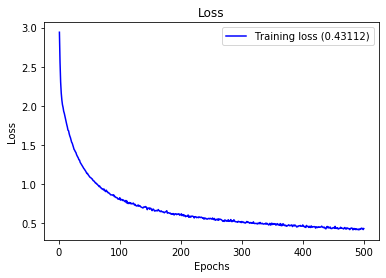

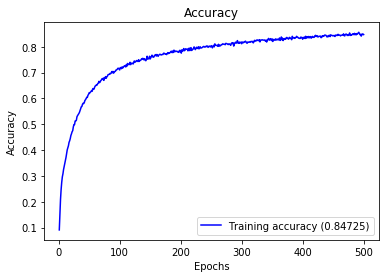

Test score: 0.8074533939361572
116.0572350025177 seconds
Model prediction accuracies based on phone acceleration data:
Walking test score: --------------------------------- 0.9265092015266418
Jogging test score: --------------------------------- 0.9365482330322266
Stairs test score: ---------------------------------- 0.901129961013794
Sitting test score: --------------------------------- 0.8047493696212769
Standing test score: -------------------------------- 0.8701298832893372
Typing test score: ---------------------------------- 0.8248587846755981
Brushing teeth test score: -------------------------- 0.8025974035263062
Eating soup test score: ----------------------------- 0.728723406791687
Eating chips test score: ---------------------------- 0.6603773832321167
Eating pasta test score: ---------------------------- 0.6440678238868713
Drinking from a cup test score: --------------------- 0.7201017737388611
Eating sandwich test score: ------------------------- 0.777479887008667
Kicking 

In [30]:
# list attributes and label of choice
attributes = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'RESULTANT']
label = 'ACTIVITY'
testsize = 0.3 # use a 70/30 train/test split

# initiate and run model
model = Model(df)
model.preprocess(attributes, label, testsize)
model.train(kfold=False) # Use train/test split for training instead of kfold
model.evaluate()